#### Load HOG-SVM model from file

In [166]:
from sklearn import svm
from joblib import load

# Load SVM model from file
svm_model = load('is_plate.joblib')

### slide a window over the image we want to detect the plates on

In [167]:
import cv2
from skimage.feature import hog

PLATE = 1
NO_PLATE = 0
def detect_plates(test_image):
    # Load test image and convert to grayscale
    test_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

    # Define HOG parameters
    orientations = 9
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)
    block_norm = 'L2-Hys'
    transform_sqrt = True
    feature_vector = True

    # Define sliding window parameters
    window_size = (96, 22)
    step_size = 8

    # Define pyramid parameters
    pyramid_scale = 1.5
    pyramid_levels = 6

    detections = []

    for level in range(pyramid_levels):
        scale = pyramid_scale ** level
        scaled_image = cv2.resize(test_gray, (int(test_gray.shape[1] / scale), 
                                            int(test_gray.shape[0] / scale)))
        for y in range(0, scaled_image.shape[0] - window_size[1], step_size):
            for x in range(0, scaled_image.shape[1] - window_size[0], step_size):
                # Extract window from image
                window = scaled_image[y:y+window_size[1], x:x+window_size[0]]

                # Compute HOG features for window
                window_features = hog(window, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                    cells_per_block=cells_per_block, block_norm=block_norm,
                                    transform_sqrt=transform_sqrt, feature_vector=feature_vector)

                # Predict label for window using SVM model
                label = svm_model.predict(window_features.reshape(1, -1))
                confidences = svm_model.decision_function(window_features.reshape(1, -1))

                # If label is positive, draw a green rectangle around window
                if label == PLATE:
                    # Scale coordinates of window back to original image size
                    x_scaled = int(x * scale)
                    y_scaled = int(y * scale)
                    x_scaled_end = int((x+window_size[0]) * scale)
                    y_scaled_end = int((y+window_size[1]) * scale)
                    area = (x_scaled_end - x_scaled) * (y_scaled_end - y_scaled)
                    detections.append((x_scaled, y_scaled, x_scaled_end, y_scaled_end, confidences[0], scale))
    return detections

#### handle overlaps

In [168]:
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    iou = intersection / union
    return iou

def handle_overlaps(detections):
    
    detections.sort(key=lambda x: x[4] * x[5], reverse=True)
    iou_threshold = 0.5
    confidence_threshold = 0.2
    selected_detections = []
    for i in range(len(detections)):
        # If current detection has confidence score below threshold, stop processing
        if detections[i][4] < confidence_threshold:
            break
        # Add current detection to selected detections list
        selected_detections.append(detections[i])
        # Loop over remaining detections and suppress any detections with significant overlap
        for j in range(i+1, len(detections)):
            if detections[j][4] < confidence_threshold:
                continue
            iou = calculate_iou(selected_detections[-1][:4], detections[j][:4])
            if iou > iou_threshold:
                detections[j] = (detections[j][0], detections[j][1], detections[j][2], detections[j][3], 0, detections[j][5])

    return selected_detections

#### mark plates with green boxes and show image

In [169]:
def mark_selection(test_image, selected_detections):
    for detection in selected_detections:
        x1, y1, x2, y2, confidence, _ = detection
        cv2.rectangle(test_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

In [170]:
from IPython.display import display, Image

def display_on_notebook(test_image):
    # Convert image to JPEG format
    ret, jpeg = cv2.imencode('.jpg', test_image)

    # Display image in notebook
    display(Image(data=jpeg.tobytes()))

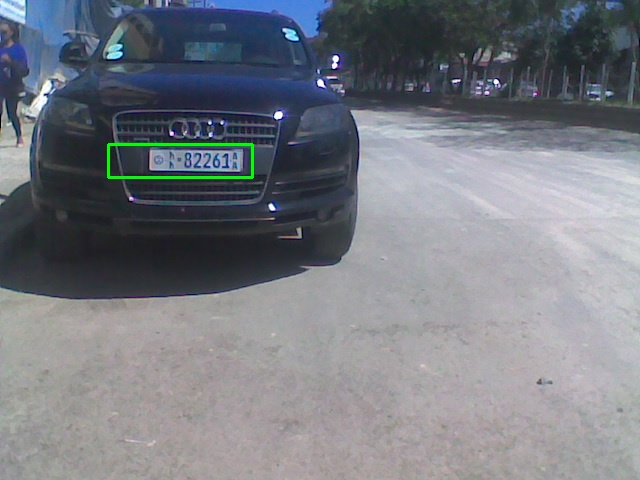

In [171]:

test_image = cv2.imread('test_set/test06.jpg')
detections = detect_plates(test_image)
selected_detections = handle_overlaps(detections)
mark_selection(test_image, selected_detections)
display_on_notebook(test_image)